# Sales Conversion Optimization - A/B Test with Hypothesis Testing

- By: Tien Nguyen
- [GitHub](https://github.com/tienngm2049)
- [LinkedIn](https://www.linkedin.com/in/tienngm2049/)
- Objective: Conduct Hypothesis Testing to evaluate the result of A/B Testing.

## Dataset Overview

**Dataset**: [Sales Conversion Optimization](https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking)

**Project Overview**:
The central objective of this project is to evaluate the effectiveness of three distinct ad campaigns conducted by an anonymous organization on Facebook in 2017. This evaluation primarily revolves around key performance indicators (KPIs), with a strong focus on conversion and approved conversion rates. To carry out this analysis, I will employ a range of methodologies, encompassing data preprocessing, data analysis to A/B testing. These techniques will enable me to ascertain whether the impact of each marketing campaign is causally linked to the observed outcomes in terms of conversion and approved conversion.

**Table of Variable Descriptions**:

| Variable           | Description                                                                                     |
|--------------------|-------------------------------------------------------------------------------------------------|
| ad_id              | Unique ID for each ad.                                                                          |
| xyz_campaign_id    | ID associated with each ad campaign conducted by XYZ company.                                    |
| fb_campaign_id     | ID associated with how Facebook tracks each campaign.                                            |
| age                | Age of the person to whom the ad is shown.                                                       |
| gender             | Gender of the person to whom the ad is shown.                                                    |
| interest           | Code specifying the category to which the person's interest belongs (as per Facebook profile). |
| Impressions        | Number of times the ad was shown.                                                                |
| Clicks             | Number of clicks for that ad.                                                                    |
| Spent              | Amount paid by company XYZ to Facebook for showing the ad.                                       |
| Total conversion   | Total number of people who inquired about the product after seeing the ad.                        |
| Approved conversion| Total number of people who bought the product after seeing the ad.                                 |

The project will proceed through the following 4 phases:
1. Data Preprocessing
2. Data Analysis
3. A/B Testing
4. Insights 

The ultimate goal is to **gain insights into which marketing campaign is most effective** in terms of driving conversions and approved conversions while ensuring the robustness of the statistical analysis.



## Table of Contents
**1. [Data Preprocessing](#1.-Data-Preprocessing)**

**2. [Data Analysis](#2.-Data-Analysis)**
- 2.1. [Categorical Features](#2.1.-Categorical-Features)
- 2.2. [Numerical Features](#2.2.-Numerical-Features)
- 2.3. [Correlation between Numerical Variables](#2.3.-Correlation-between-Numerical-Variables)

**3. [A/B Testing](#3.-A/B-Testing)**
- 3.1. [Creating Metrics](#3.1.-Creating-Metrics)
- 3.2. [Checking the Normality Assumption](#3.2.-Checking-the-Normality-Assumption)
- 3.3. [Power Analysis for Sample Size](#3.3.-Power-Analysis-for-Sample-Size)
- 3.4. [Conducting Hypothesis Testing](#3.4.-Conducting-Hypothesis-Testing)

**4. [Overall Insights](#4.-Overall-Insights)**

- 4.1. [Observation on Test Results](#4.1.-Observation-on-Test-Results)
- 4.2. [Conclusion](#4.2.-Conclusion)

**5. [Recommnendations](#5.-Recommendations)**

## 1. Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.stats.power as smp
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df = pd.read_csv('KAG_conversion_data.csv')
print(df.shape)
df.head()

(1143, 11)


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


The feature names are not in the same format so I will replace it:

In [3]:
df = df.rename(columns={
    'ad_id': 'ad_id',
    'xyz_campaign_id': 'xyz_campaign_id',
    'fb_campaign_id': 'fb_campaign_id',
    'age': 'age',
    'gender': 'gender',
    'interest': 'interest',
    'Impressions': 'impression',
    'Clicks': 'click',
    'Spent': 'spent',
    'Total_Conversion': 'total_conversion',
    'Approved_Conversion': 'approved_conversion'
})

In [4]:
data = []
for col in df.columns:
    unique_values = df[col].unique()
    num_unique = len(unique_values)
    dtype = df[col].dtype
    missing = df[col].isna().sum()
    if num_unique > 10:
        data.append((col, num_unique, "", dtype, missing))
    else:
        unique_values_str = ", ".join(map(str, unique_values))
        data.append((col, num_unique, unique_values_str, dtype, missing))

uniques = pd.DataFrame(data, columns=["Column", "# of Uniques", "Unique Values (<10)", "Dtype", 'Missing'])
uniques.sort_values(by='# of Uniques').reset_index(drop=True)

,Column,# of Uniques,Unique Values (<10),Dtype,Missing
0,gender,2,"M, F",object,0
1,xyz_campaign_id,3,"916, 936, 1178",int64,0
2,age,4,"30-34, 35-39, 40-44, 45-49",object,0
3,approved_conversion,16,,int64,0
4,total_conversion,32,,int64,0
5,interest,40,,int64,0
6,click,183,,int64,0
7,fb_campaign_id,691,,int64,0
8,spent,869,,float64,0
9,impression,1130,,int64,0


In [5]:
df['xyz_campaign_id'] = df['xyz_campaign_id'].astype(str)
df['interest'] = df['interest'].astype(str)

In [6]:
# Remove `fb_campaign_id` and `ad_id` from descriptive statistics table
df[['impression', 'total_conversion', 'approved_conversion', 'click', 'spent']].describe()

,impression,total_conversion,approved_conversion,click,spent
count,1143.00,1143.00,1143.00,1143.00,1143.00
mean,186732.13,2.86,0.94,33.39,51.36
std,312762.18,4.48,1.74,56.89,86.91
min,87.00,0.00,0.00,0.00,0.00
25%,6503.50,1.00,0.00,1.00,1.48
50%,51509.00,1.00,1.00,8.00,12.37
75%,221769.00,3.00,1.00,37.50,60.02
max,3052003.00,60.00,21.00,421.00,639.95


**Summary of Cleaning:**

- All variable names have been converted to lowercase for consistency.
- No missing values were found in the dataset.
- The data type of `xyz_campaign_id` and `interest` has been changed to categorical.

**Summary of Dataset:**
- The dataset consists of 1143 rows and 11 columns.
- There are 4 categorical variables: `gender`, `xyz_campaign_id`, `age`, and `interest`.
- The remaining 7 variables are numerical data.
- `xyz_campaign_id`: Three marketing campaigns are identified with campaign IDs 916, 936, and 1178.
- `age`: Age is grouped into four categories ranging from 30 to 49 years old.

**Summary of Descriptive Statistics Table:**
- Both `total_conversion` and `approved_conversion` are notably low, with 75% of the data showing less than 3 people inquiring about the product after seeing the ad and 1 person buying the product after seeing the ad, indicating low conversion rates.
- In contrast, the number of `clicks` has a median value of 8 clicks per ad.
- The ranges of `spent`, `clicks`, and `impressions` are wide, with the maximum values significantly higher than the 75th percentile, indicating a right-skewed distribution.
- Based on the median values, for every \$1.48 spent on ads, there are approximately 51,509 impressions, but only 8 people click on the ads, and just 1 person inquires about the product and only 1 person buys the product.

That's the basics about the dataset. We will discover them in details now.

## 2. Data Analysis

In [7]:
numerical_features = [col for col in df.columns if df[col].dtype == 'int64' or df[col].dtype == 'float64']
categorical_features = [col for col in df.columns if col not in numerical_features]
print(f"{len(numerical_features)} numerical features: \n{numerical_features}")
print()
print(f"{len(categorical_features)} categorical features: \n{categorical_features}")

7 numerical features: 
['ad_id', 'fb_campaign_id', 'impression', 'click', 'spent', 'total_conversion', 'approved_conversion']

4 categorical features: 
['xyz_campaign_id', 'age', 'gender', 'interest']


### 2.1. Categorical Features

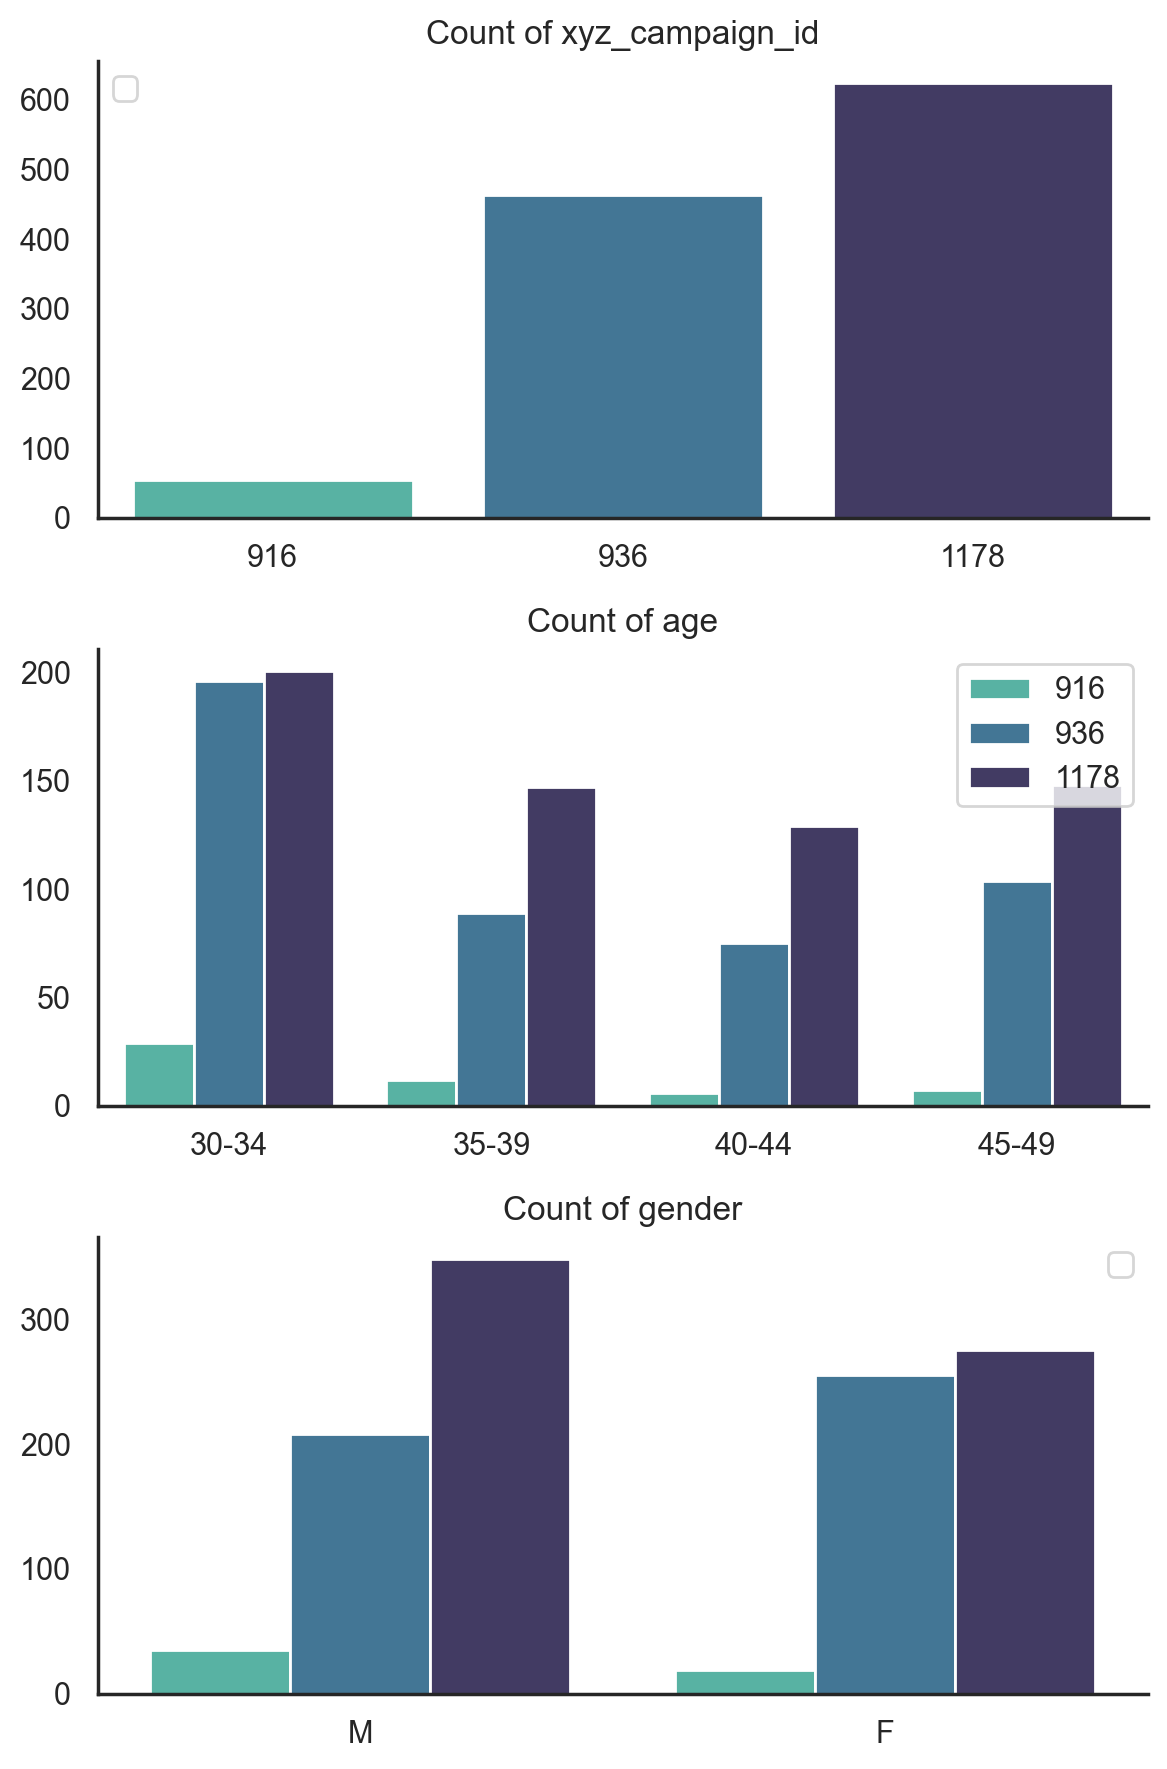

In [8]:
_, axes = plt.subplots(3, 1, figsize=(6, 9))

for i, col in enumerate(categorical_features):
    if col == 'xyz_campaign_id':
        hue = None
    elif col == 'interest':
        continue
    else:
        hue = 'xyz_campaign_id'
    ax = axes[i]
    sns.countplot(data=df, x=col, ax=ax, palette='mako_r', hue = hue)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Count of {col}')    
    [ax.legend([]) if i !=1 else ax.legend()]
plt.tight_layout();

**Note:**

- **Campaign Imbalance**: It's important to acknowledge the imbalance in the count of samples among the three campaigns (Campaign_ID 936 and 1178 having larger samples, while 916 has under 60 samples). This imbalance can indeed impact the results of statistical tests. In statistical analysis, larger sample sizes generally provide more statistical power, making it easier to detect significant differences if they exist. Conversely, smaller sample sizes can reduce the ability to detect smaller differences.

To address this issue, we can employ a resampling technique known as **Bootstrapping**. Bootstrapping involves creating multiple resamples (with replacement) from the available data. This technique helps us estimate the distribution of statistics (e.g., mean, median, etc.) and assess the robustness of our results, even when dealing with imbalanced sample sizes.

- **Age**: It's noteworthy that the age group "30-34" seems to be more prominently represented in the campaign compared to other age groups. This insight can be valuable for targeted marketing efforts, as it suggests a potential focus on this age range for future campaigns.

- **Gender**: The data indicates a relatively balanced distribution between men and women in terms of campaign involvement exceot for campaign 1178, with more men involved than women.


### 2.2. Numerical Features

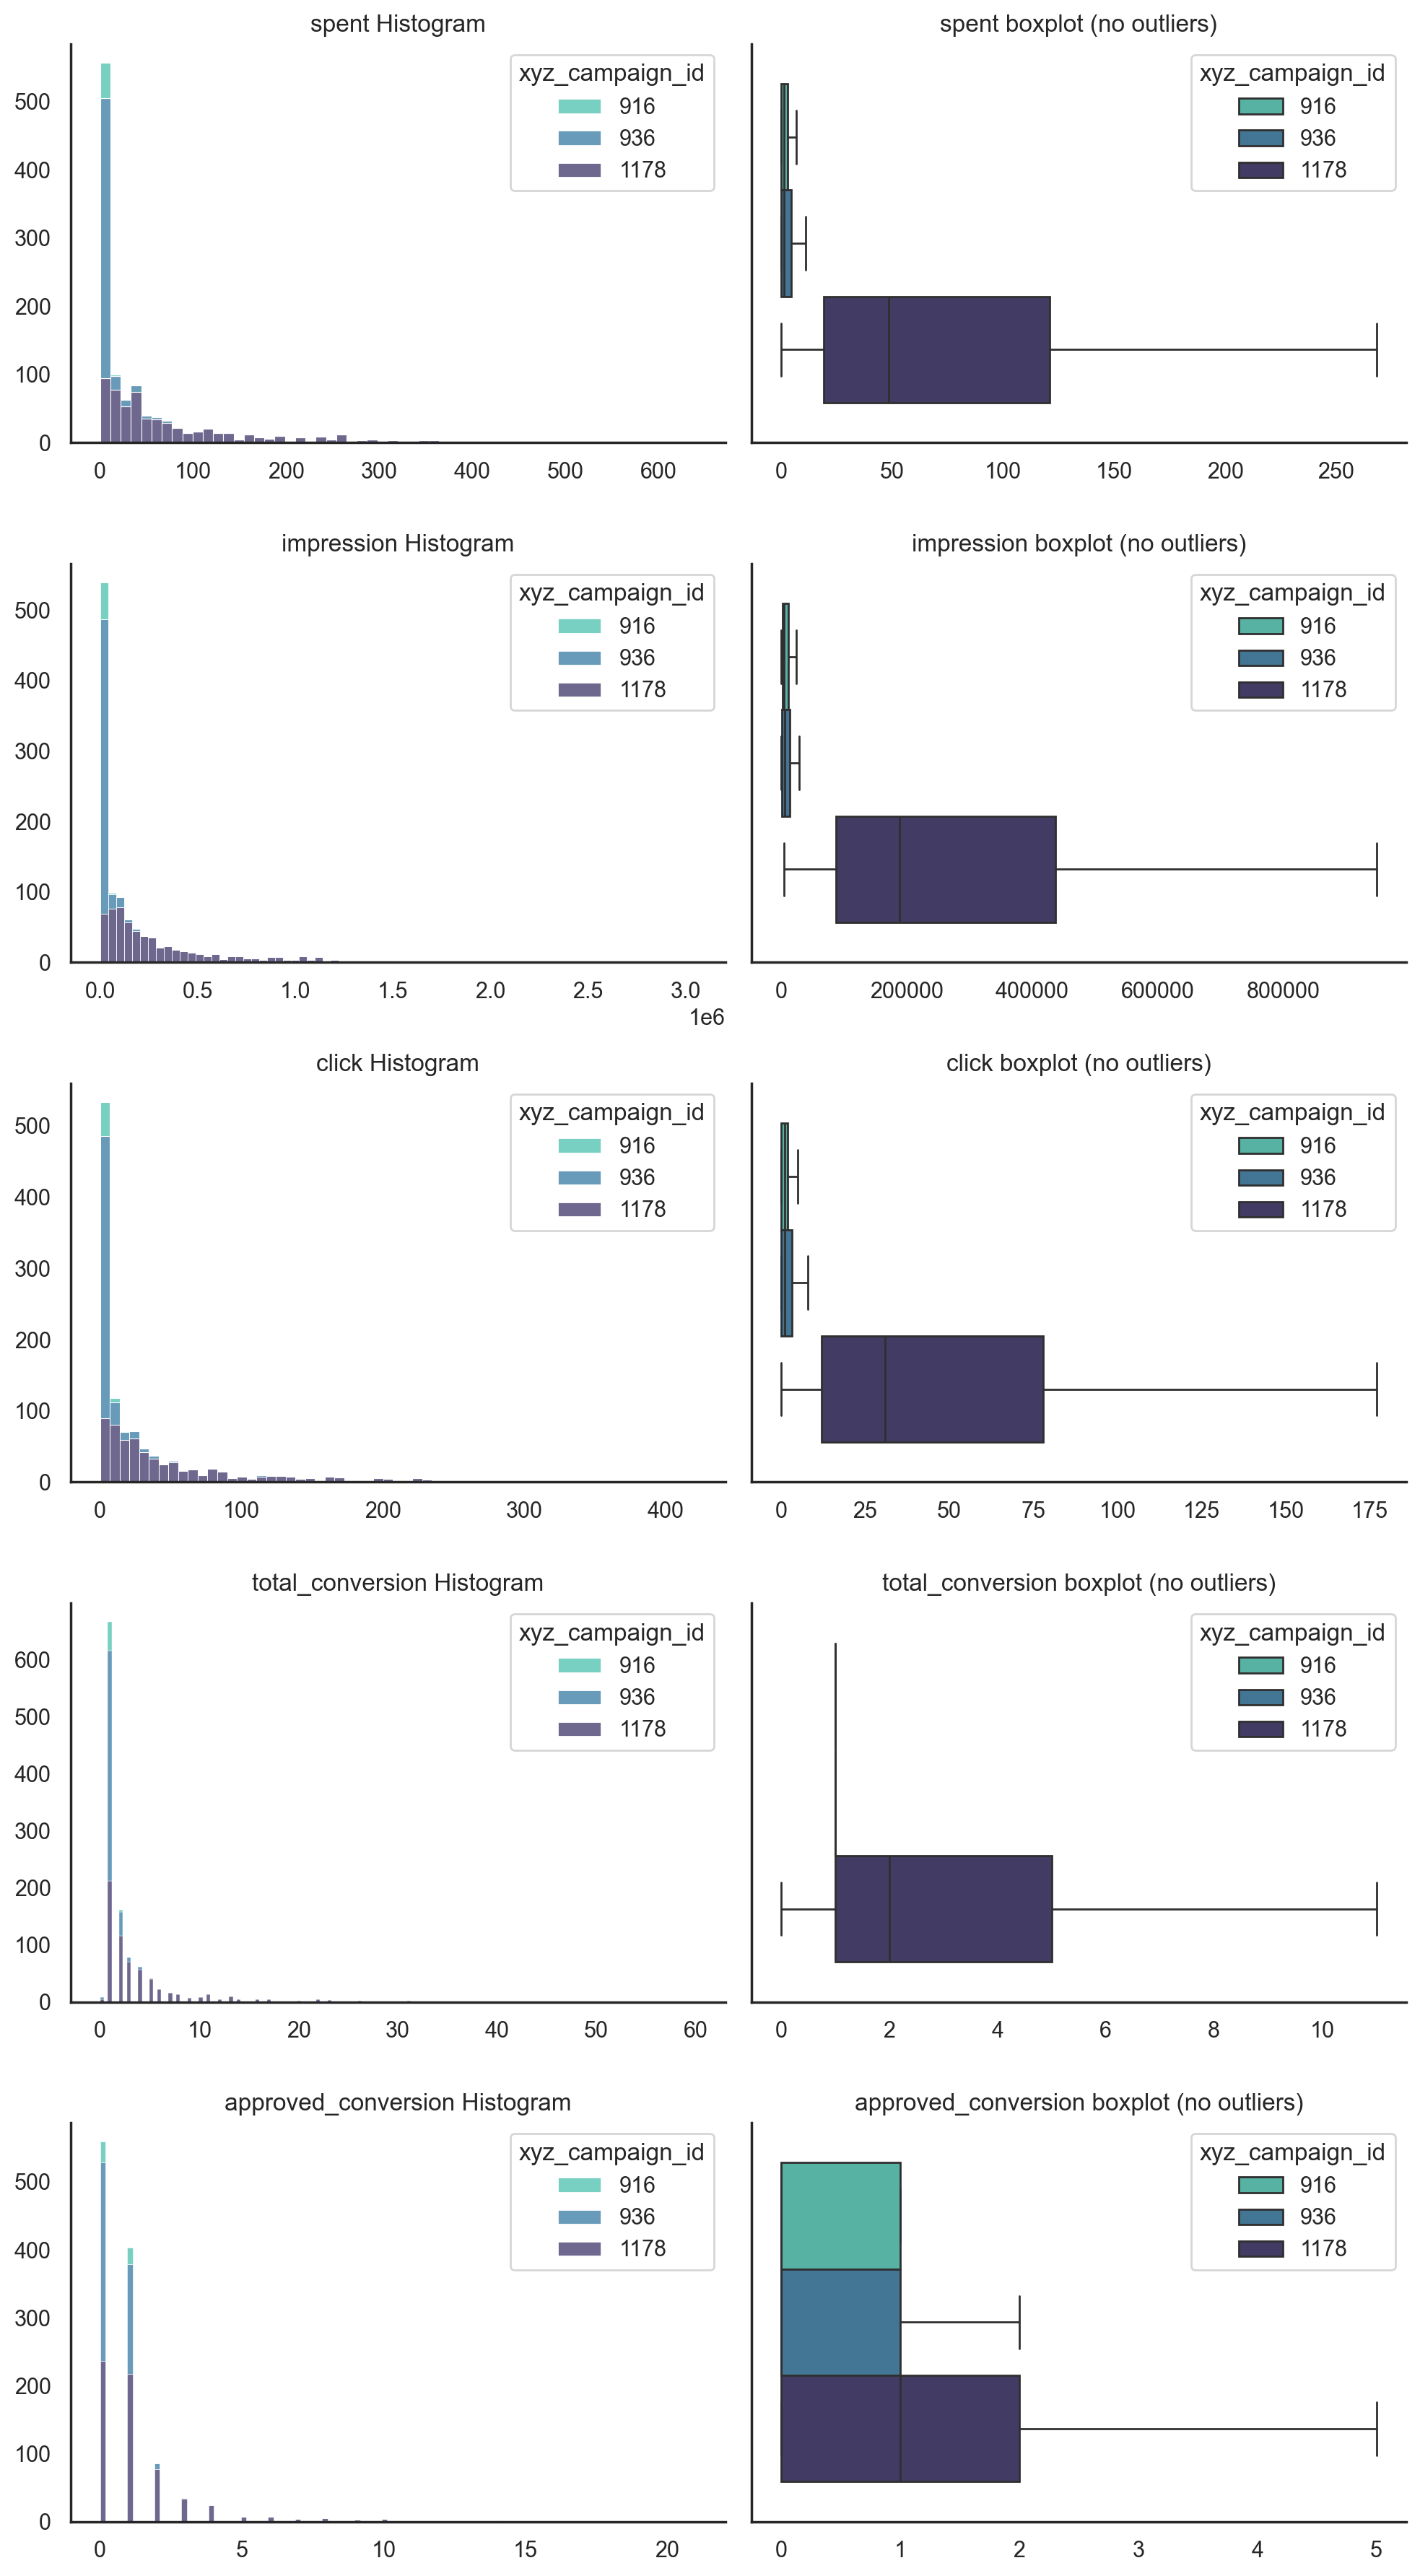

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(10, 18))

selected_num_cols = [
    'spent',
    'impression',  
    'click', 
    'total_conversion', 
    'approved_conversion'
]

for i, col in enumerate(selected_num_cols):
    # Plot histogram
    sns.histplot(data=df, x=col, ax=axes[i, 0], color='c', hue='xyz_campaign_id', palette='mako_r', multiple='stack')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')
    axes[i, 0].set_title(f'{col} Histogram')

    # Plot boxplot without outliers
    sns.boxplot(data=df, x=col, ax=axes[i, 1], color='c', showfliers=False, hue='xyz_campaign_id', palette='mako_r')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')
    axes[i, 1].set_title(f'{col} boxplot (no outliers)')

plt.tight_layout()
plt.show()


**Note:**

- Outliers are present in all numerical features across the dataset, emphasizing the importance of examining boxplots after removing them for a more accurate representation.

- The campaign with ID 1178 has the widest range of `spent`, consequently influencing other variables associated with it. In contrast, campaigns 916 and 936 had relatively small budgets, leading to lower metrics such as `impression`, `click`, and `conversion`.

- Focusing on boxplots without outliers provides a clearer view of the distribution and central tendency of each variable, allowing for more accurate comparisons between campaigns.

- It's evident that XYZ company invested significantly more resources in conducting campaign 1178, leading to higher results in terms of various metrics.

### 2.3. Correlation between Numerical Variables

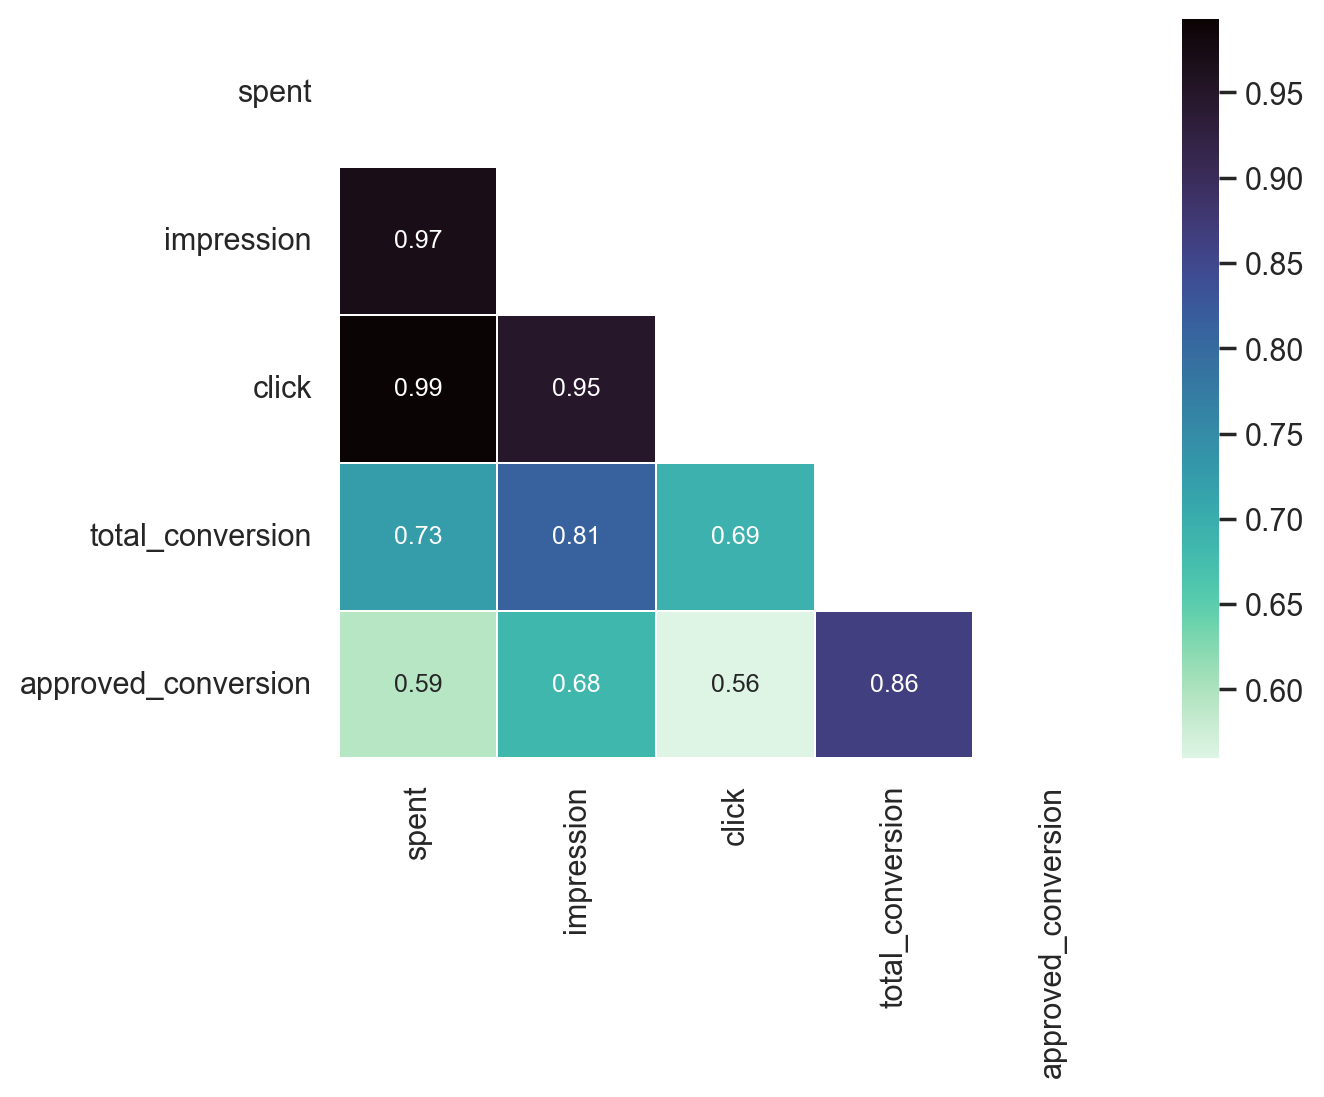

In [10]:
corr = df[selected_num_cols].corr(numeric_only=True)
sns.heatmap(
    corr, 
    annot=True, 
    cmap='mako_r', 
    mask=np.triu(corr), 
    linewidth=0.1, 
    linecolor='w', 
    fmt='.2f', 
    annot_kws={'size':9}
   );

**Note:** 
- The heatmap analysis reveals strong correlations among variables. This is quite obvious because they follow a sequence. Starting with the money spent on ads (`spent`), it leads to the number of people seeing the ads (`impression`), followed by the number of clicks on the ads (`click`). Subsequently, there might be inquiries about the products (`total_conversion`) and, ultimately, purchases (`approved_conversion`).

- What is interesting is that the correlation coefficient of `click`, `spent`, and `impression` to each other is nearly 1,  indicating that as one of these variables increases, the others are likely to increase as well. However, correlation does not imply causation. While there is a strong association between these variables, it doesn't necessarily mean that one variable causes the other.

- However, the correlation coefficient between `click` and `approved_conversion` is the lowest, just 0.56, indicating that the relationship between the number of clicks and the approved conversions is not as strong as the relationship between other variables. 





## 3. A/B Testing

**Conversion Goals - Metrics Will Be Used:**

1. **Conversion Rate (CR):**
   The conversion rate, a pivotal metric, encapsulates the essence of success by gauging the percentage of users who engage in the desired action—whether it's making a purchase, signing up, or any other conversion event. Expressed as the ratio of the number of conversions to the total number of visitors, multiplied by 100, the conversion rate stands as a fundamental measure of the effectiveness of A/B testing.

   `Conversion rate = (Number of conversions / Total number of visitors) x 100 %`

3. **Click-through Rate (CTR):**
   The click-through rate (CTR) serves as a compass for user engagement, providing insights into the significance of clickable website elements. By calculating the proportion of clicks to impressions, expressed as a percentage, the CTR illuminates how effectively your content resonates with the intended audience and encourages interaction.

   `CTR = (Clicks / Impressions) x 100 %`

5. **Cost per Click (CPC):**
   The cost per click (CPC) delves into the financial aspect, examining the expenditure required to generate each click. CPC scrutinizes the economic viability of acquiring user attention, thereby facilitating an evaluation of the efficiency of your advertising expenditure.

   `CPC = ( Cost / Clicks) $`

**Hypothesis**

- **H0 (Null Hypothesis)**: There is no difference in the central tendency (median) of the variables (CR, CTR, and CPC) between the different campaign groups in the population.

- **H1 (Alternative Hypothesis)**: There is a significant difference in the central tendency (median) of the variables (CR, CTR, and CPC) between the different campaign groups in the population.

### 3.1. Creating Metrics

In [11]:
# Percentage of people bought the product to total impressions
df["CR"] = df["approved_conversion"] / df["impression"] * 100

# Percentage of clicks to impressions
df["CTR"] = df["click"] / df["impression"] * 100

# The money spent per click
df["CPC"] = df["spent"] / df["click"]

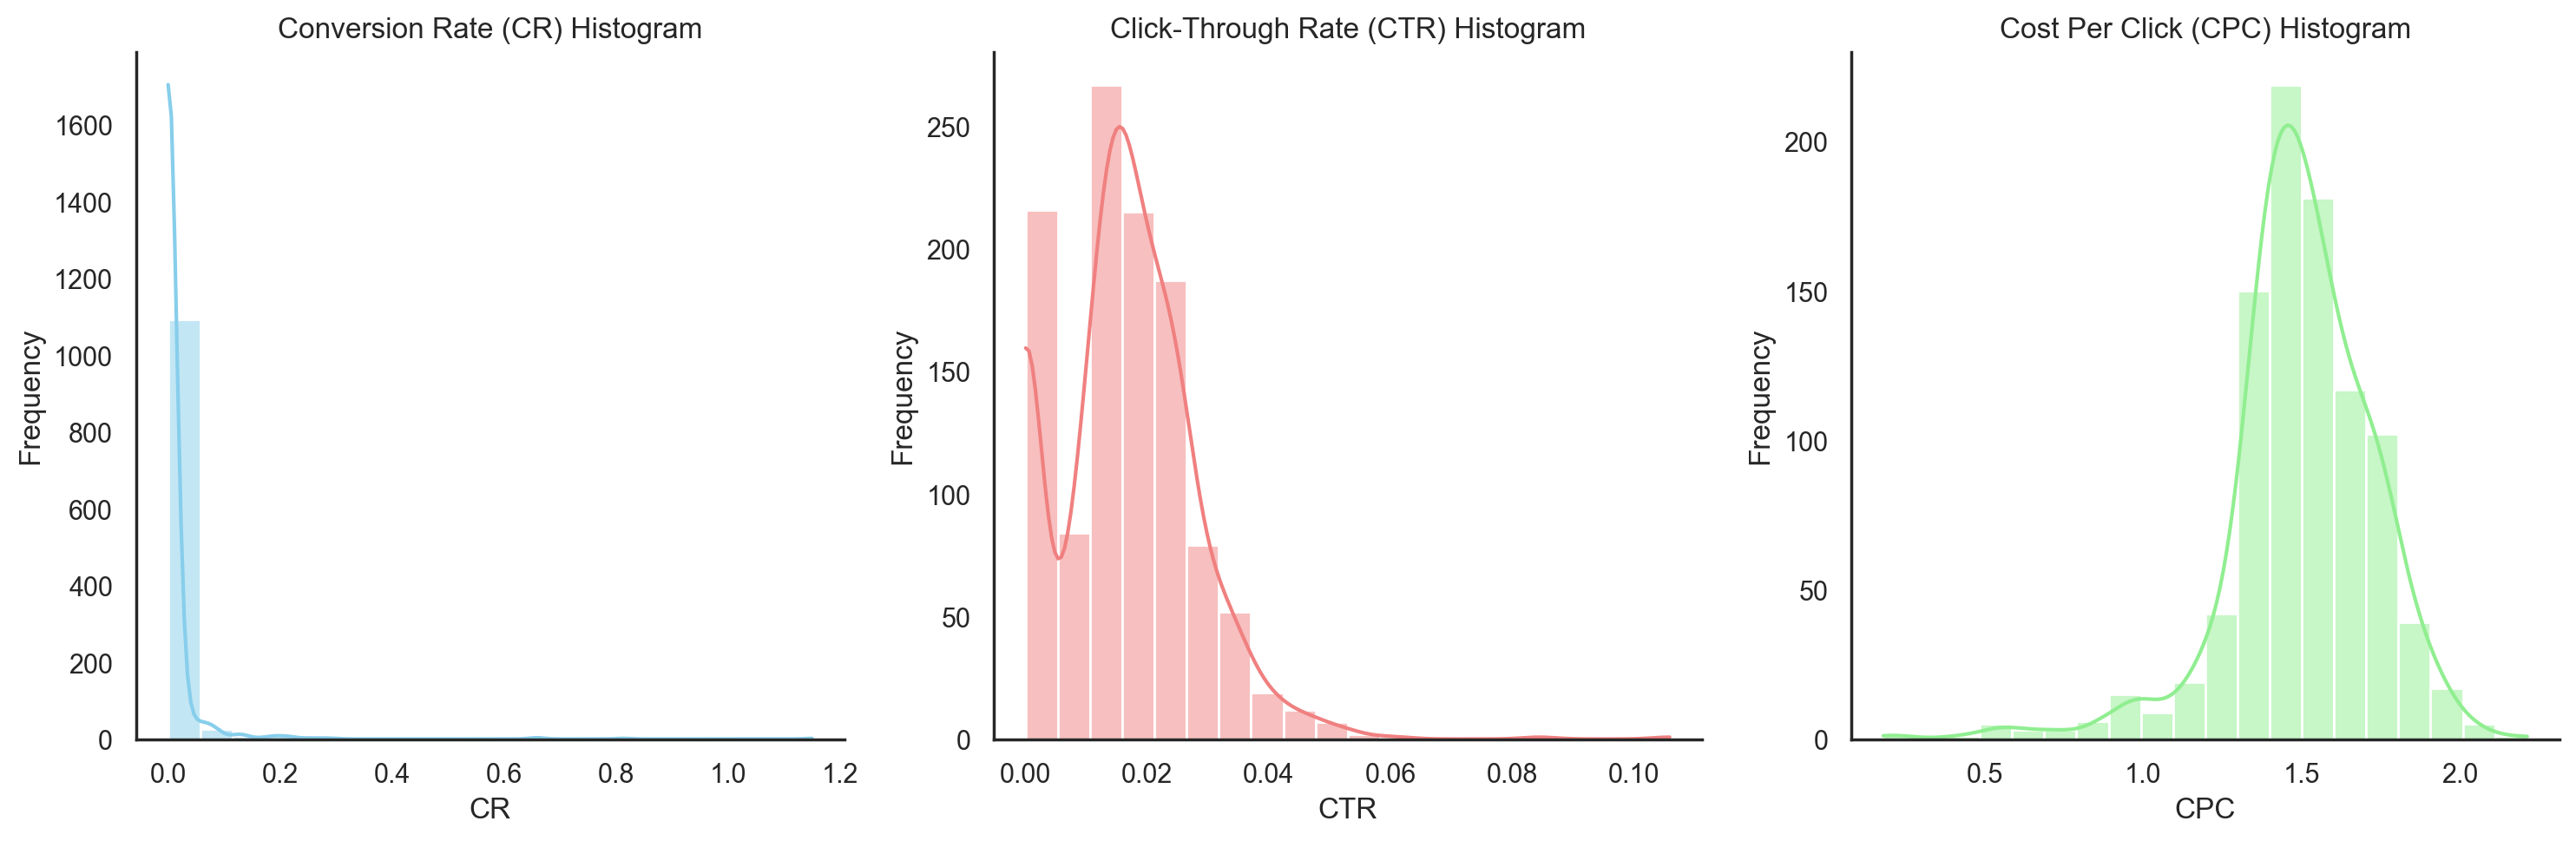

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df["CR"], bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_title("Conversion Rate (CR) Histogram")
axs[0].set_xlabel("CR")
axs[0].set_ylabel("Frequency")

sns.histplot(df["CTR"], bins=20, kde=True, color='lightcoral', ax=axs[1])
axs[1].set_title("Click-Through Rate (CTR) Histogram")
axs[1].set_xlabel("CTR")
axs[1].set_ylabel("Frequency")

sns.histplot(df["CPC"], bins=20, kde=True, color='lightgreen', ax=axs[2])
axs[2].set_title("Cost Per Click (CPC) Histogram")
axs[2].set_xlabel("CPC")
axs[2].set_ylabel("Frequency")

plt.tight_layout();

In [13]:
df.groupby('xyz_campaign_id')[['CR', 'CTR', 'CPC']].agg(['count', 'min', 'median', 'max']).round(3)

CR                    CTR                    CPC       \
                count  min median  max count  min median  max count  min   
xyz_campaign_id                                                            
1178              625 0.00   0.00 0.01   625 0.00   0.02 0.04   613 1.15   
916                54 0.00   0.00 0.10    54 0.00   0.02 0.05    35 0.57   
936               464 0.00   0.00 1.15   464 0.00   0.02 0.11   288 0.18   

                             
                median  max  
xyz_campaign_id              
1178              1.54 2.21  
916               1.35 1.69  
936               1.39 2.01

**Comment on metrics distribution and values:**

- **Conversion Rate (CR):** The histogram for Conversion Rate indicates that the majority of values fall within the range of 0% to 0.1%. This suggests a low conversion rate, highlighting the challenge in converting impressions to actual conversions.

- **Click-Through Rate (CTR):** The histogram for Click-Through Rate shows a right-skewed distribution, with most values concentrated in the range of 0% to 0.04%. This indicates a relatively low click-through rate, emphasizing the need to enhance user engagement and interaction with the ads.

- **Cost Per Click (CPC):** The distribution of Cost Per Click appears relatively normal, with values concentrated around $1 to $1.7. The presence of a small tail at the low end suggests some instances of efficient budget spending, particularly for campaigns 916 and 936.

- **Aggregation Table Insights:** While there isn't a significant difference in CR and CTR across the three campaigns, the CPC values reveal distinctions. Campaigns 916 and 936 have lower CPC values compared to 1178, indicating more cost-efficient budget utilization.
  
- **Null:** The count of CPC values is smaller than the other two metrics, potentially due to the formula \(CPC = \frac{\text{spent}}{\text{click}}\), resulting in null values for rows with zero clicks. Further investigation into zero-click scenarios may provide additional insights.
 efficiency.

In [14]:
df[df['click'] == 0]['click'].count()

207

**Handling Missing Values in CPC**

Upon examination of the `Clicks` variable, it was discovered that there are 207 instances where `Clicks` equals 0. In such cases, imputing missing CPC (Cost Per Click) values to 0 would not accurately represent the cost per click because there were no clicks to calculate the cost against. Imputing zeros in these cases might mislead interpretations by suggesting that there were clicks, but they were free (zero cost).

Instead, a more appropriate approach is to **still treat missing CPC values as null** when `Clicks` is 0. This treatment accurately reflects the absence of clicks and ensures that the cost per click is undefined in cases where no actual clicks occurred.

For the statistical analysis of CPC, the size of the bootstrap sample will be adjusted to work with valid data points where `Clicks` is greater than 0. This ensures that the analysis is based on meaningful data and excludes cases where there were no actual clicks.

This approach maintains the integrity of the analysis and provides a more accurate representation of the cost per click in situations where clicks did not occur.

**We also see that there's a imbalanced lass between 3 campaigns so we need to deal with this to choose suitable sample size:**

In [15]:
df.groupby('xyz_campaign_id')[["CR", "CTR", "CPC"]].count()

,CR,CTR,CPC
xyz_campaign_id,,,
1178,625,625,613
916,54,54,35
936,464,464,288


### 3.2. Checking the Normality Assumption

Before proceeding with hypothesis testing, it's essential to assess whether the distributions of the three metrics are normal or not. This step will help determine whether to use a parametric t-test or a non-parametric Mann-Whitney U test for hypothesis testing.

There are two ways to approach this:

1. **Visual Inspection**: It's also a good practice to create Q-Q plots or histograms for each metric and visually inspect the distribution. If the data deviates significantly from a normal distribution in these plots, it's an indicator of non-normality.

2. **Shapiro-Wilk Test**: We can use the Shapiro-Wilk test to check the normality of each metric's distribution. The null hypothesis of this test is that the data follows a normal distribution. If the p-value from the test is less than the chosen alpha level (typically 0.05), we reject the null hypothesis and conclude that the data does not follow a normal distribution.

#### 3.2.1. Q-Q Plot

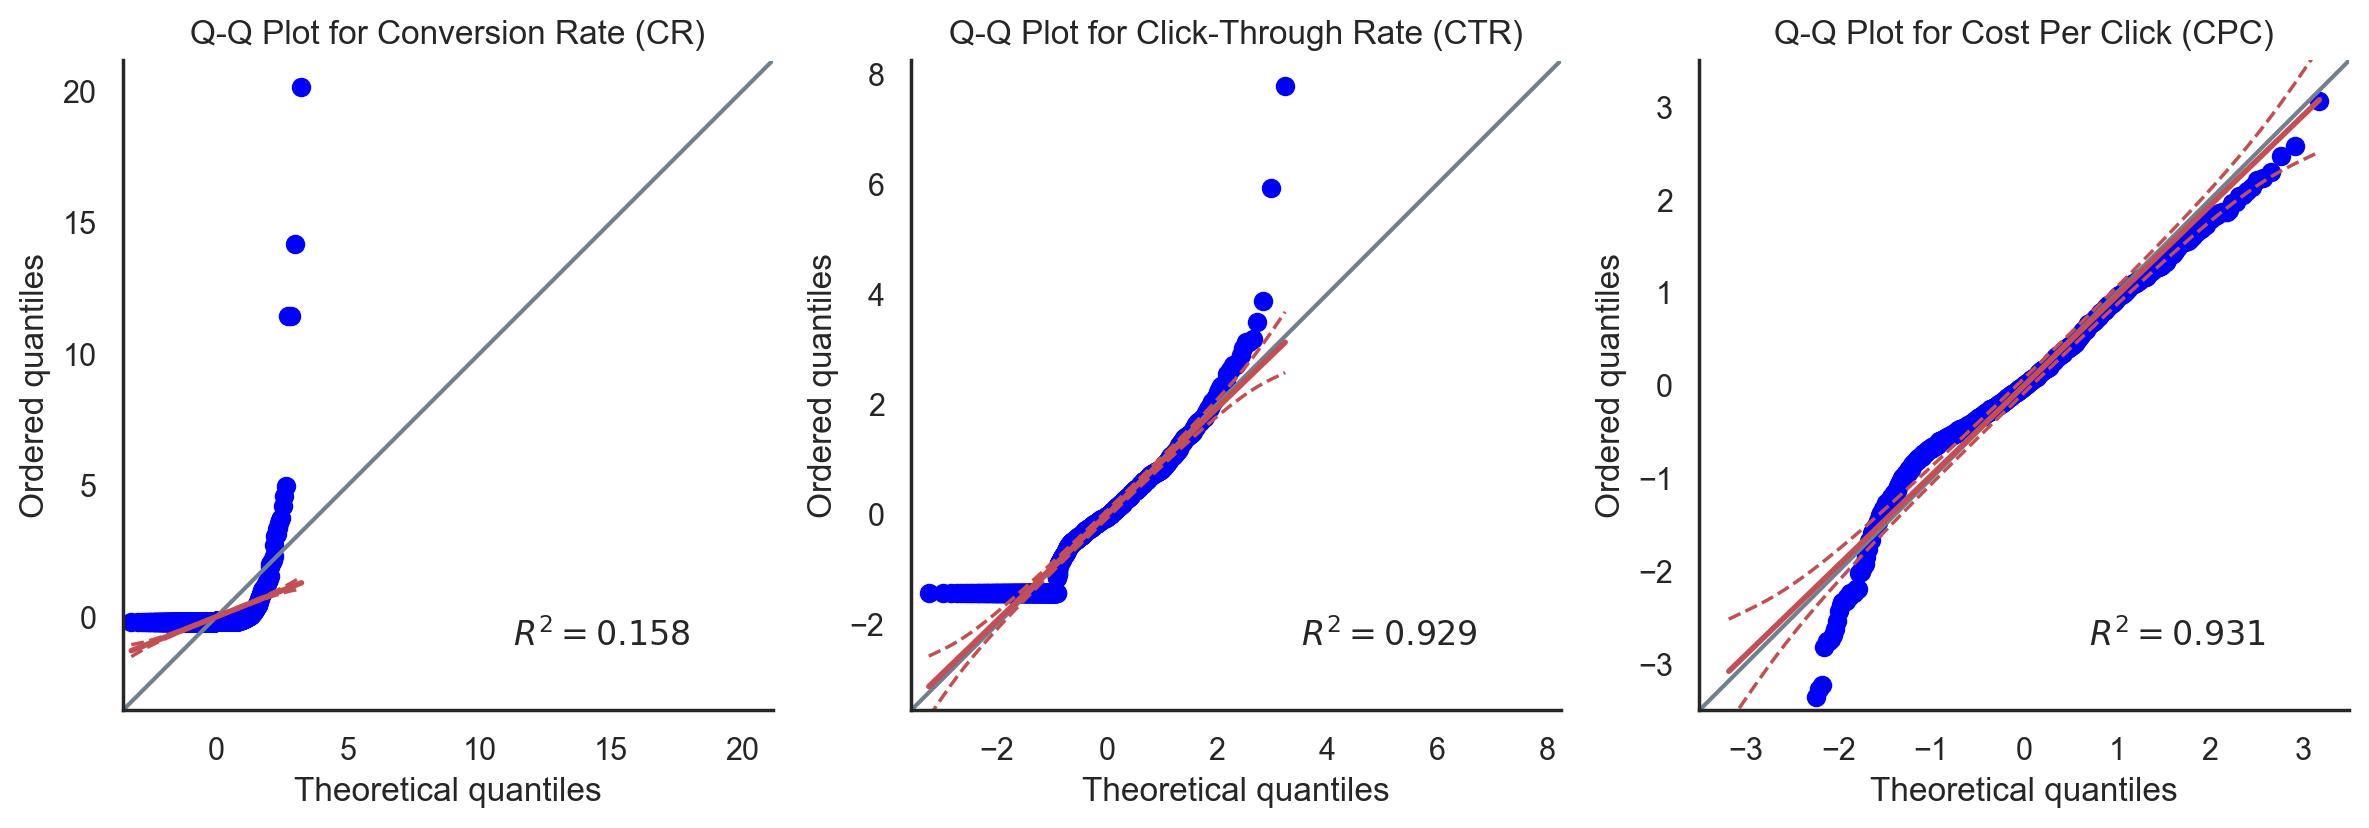

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Create Q-Q plot for "CR" (Conversion Rate)
pg.qqplot(df["CR"], dist='norm', ax=ax[0])
ax[0].set_title("Q-Q Plot for Conversion Rate (CR)")

# Create Q-Q plot for "CTR" (Click-Through Rate)
pg.qqplot(df["CTR"], dist='norm', ax=ax[1])
ax[1].set_title("Q-Q Plot for Click-Through Rate (CTR)")

# Create Q-Q plot for "CPC" (Cost Per Click)
pg.qqplot(df["CPC"], dist='norm', ax=ax[2])
ax[2].set_title("Q-Q Plot for Cost Per Click (CPC)")

plt.tight_layout();

**Note:**

The R-squared (R²) values indicate the goodness of fit for Q-Q plots of the "CR" (Conversion Rate), "CTR" (Click-Through Rate), and "CPC" (Cost Per Click) variables. These values tell us how well the observed data points fit the expected quantiles of a normal distribution. Here's what each R² value implies:

1. CR (Conversion Rate):
   - R² = 0.352
   - An R² of 0.352 suggests that the observed data points for Conversion Rate moderately fit the expected quantiles of a normal distribution, which suggest this is not a normal distribution.

2. CTR (Click-Through Rate):
   - R² = 0.929
   - An R² of 0.929 indicates that the observed data points for Click-Through Rate fit the expected quantiles of a normal distribution very well. This suggests that the CTR variable is quite close to a normal distribution.

3. CPC (Cost Per Click):
   - R² = 0.931
   - An R² of 0.931 also suggests that the observed data points for Cost Per Click fit the expected quantiles of a normal distribution very well. Similar to CTR, this indicates that the CPC variable is very close to a normal distribution.

**In summary, based on the R² values:**
- CR has a moderate fit to a normal distribution.
- CTR and CPC both have a strong fit to a normal distribution, indicating that they closely resemble normal distributions.

Now let's use shapiro test to re-check normality:

#### 3.2.2. Shapiro-Wilk Test

In [17]:
# Define campaign IDs
campaign_ids = ['916', '936', '1178']

# Initialize an empty DataFrame to store the Shapiro-Wilk test results
shapiro_results = pd.DataFrame(columns=["campaign_id", "variable", "W", "pval", "normal"])

# Perform Shapiro-Wilk test for each campaign and each variable
for campaign_id in campaign_ids:
    # Filter data for the specified campaign ID
    data_campaign = df[df["xyz_campaign_id"] == campaign_id]
    
    # Perform Shapiro-Wilk test for CR (Conversion Rate)
    shapiro_cr = pg.normality(data_campaign["CR"])
    shapiro_cr["variable"] = "CR"
    
    # Perform Shapiro-Wilk test for CTR (Click-Through Rate)
    shapiro_ctr = pg.normality(data_campaign["CTR"])
    shapiro_ctr["variable"] = "CTR"
    
    # Perform Shapiro-Wilk test for CPC (Cost Per Click)
    shapiro_cpc = pg.normality(data_campaign["CPC"])
    shapiro_cpc["variable"] = "CPC"
    
    # Add the Campaign ID to each result
    shapiro_cr["campaign_id"] = campaign_id
    shapiro_ctr["campaign_id"] = campaign_id
    shapiro_cpc["campaign_id"] = campaign_id

    # Concatenate the results to the DataFrame
    shapiro_results = pd.concat([shapiro_results, shapiro_cr, shapiro_ctr, shapiro_cpc], ignore_index=True)
    
shapiro_results["normal"] = shapiro_results["normal"].astype(bool)
print("Shapiro-Wilk Test for CR, CTR, and CPC for each campaign group:")
shapiro_results

Shapiro-Wilk Test for CR, CTR, and CPC for each campaign group:


,campaign_id,variable,W,pval,normal
0,916,CR,0.64,0.00,False
1,916,CTR,0.88,0.00,False
2,916,CPC,0.91,0.01,False
3,936,CR,0.26,0.00,False
4,936,CTR,0.87,0.00,False
5,936,CPC,0.92,0.00,False
6,1178,CR,0.57,0.00,False
7,1178,CTR,0.99,0.00,False
8,1178,CPC,0.98,0.00,False


**Notes on Shapiro-Wilk Test result and Imbalanced Class:**

Shapiro-Wilk Test result:

- After conducting the Shapiro-Wilk tests, it's clear that the assumptions of normality are violated for all the CR (Conversion Rate), CTR (Click-Through Rate), and CPC (Cost Per Click) variables.

- When faced with non-normal data distributions, we cannot employ parametric tests like ANOVA or the t-test. In such cases, it's more appropriate to utilize non-parametric tests such as the **Kruskal-Wallis test** or the **Mann-Whitney U test**.

Imbalanced Class:

- However, in scenarios where we encounter imbalanced sample sizes, these non-parametric tests may **lack the necessary statistical power** to effectively detect differences between groups. To address this challenge, there are a couple of strategies we can consider:
    - One option is to contemplate increasing the sample size, particularly in the smaller groups. This can enhance the test's power to detect meaningful differences. However, it's important to acknowledge that gathering additional data can be time-consuming and resource-intensive and within limit of this dataset it's impossible. 
    - Alternatively, we can leverage **bootstrapping**, a statistical technique employed to estimate the uncertainty associated with a statistical test. Bootstrapping involves the repetitive resampling of the available data and re-running the test. This iterative process generates a distribution of p-values, which, in turn, enables us to calculate a confidence interval for the p-value.

In the context of our case, we can *apply bootstrapping to estimate the statistical power of the Kruskal-Wallis test and the Mann-Whitney U test*. This entails repeatedly resampling the dataset, applying the chosen non-parametric test, and recording the results. By analyzing the distribution of p-values obtained from these iterations, we can effectively estimate the power of the test. 

### 3.3. Power Analysis for Sample Size

Power analysis is a crucial aspect of experimental design and statistical hypothesis testing. It helps us determine the appropriate sample size needed to detect a meaningful effect with a certain level of statistical power.

Key parameters:

1. **Statistical Power (Power):** Statistical power, often denoted as "power," is the probability of correctly rejecting a null hypothesis when it is false. In other words, it represents the ability of a statistical test to detect an effect if it exists in the population. Power is typically expressed as a value between 0 and 1, where higher values indicate greater sensitivity to detect effects. Researchers often aim for a minimum power level of 0.80 (80%) or higher.

2. **Effect Size (Effect Size):** Effect size measures the magnitude or strength of the relationship or difference being studied. It quantifies how large or meaningful the effect is in practical terms. The choice of effect size depends on the research question and the specific statistical test being used. Common effect size measures include Cohen's d, eta-squared (η²), and odds ratios, among others.

3. **Significance Level (Alpha, α):** The significance level, denoted as α (alpha), represents the probability of making a Type I error (false positive). It determines the threshold for statistical significance. Commonly used values for α are 0.05 (5%) and 0.01 (1%).

4. **Sample Size (n):** Sample size is the number of observations or participants included in a study. It directly influences the precision and power of a statistical test. A larger sample size generally increases the ability to detect effects and reduces the margin of error.

Because we don't have a direct way to calculate sample size for non-parametric test so I will use the `NormalIndPower()` function instead. While originally designed for normal independent t-tests, it can be adapted to estimate sample size for non-parametric tests as well.

In [18]:
power = 0.8
alpha = 0.05
effect_size = 0.5
sample_sizes = {
    'CR': {'1178': 625, '916': 54, '936': 464},
    'CTR': {'1178': 625, '916': 54, '936': 464},
    'CPC': {'1178': 613, '916': 35, '936': 288}
}

required_sample_sizes = {}
for variable in sample_sizes.keys():
    required_sample_sizes[variable] = {}
    for campaign_id, sample_size in sample_sizes[variable].items():

        nobs2 = smp.TTestIndPower().solve_power(
            effect_size=effect_size, 
            alpha=alpha, 
            power=power, 
            alternative='two-sided')

        required_sample_sizes[variable][campaign_id] = int(nobs2)

for variable, campaign_sizes in required_sample_sizes.items():
    print(f"Required Sample Sizes for {variable}:")
    for campaign_id, sample_size in campaign_sizes.items():
        print(f"- Campaign {campaign_id}: {sample_size}")

Required Sample Sizes for CR:
- Campaign 1178: 63
- Campaign 916: 63
- Campaign 936: 63
Required Sample Sizes for CTR:
- Campaign 1178: 63
- Campaign 916: 63
- Campaign 936: 63
Required Sample Sizes for CPC:
- Campaign 1178: 63
- Campaign 916: 63
- Campaign 936: 63


**So our sample size for all tests will be 63.**

### 3.4. Conducting Hypothesis Testing

In this section, I will perform hypothesis testing to assess whether there is a significant difference in the central tendency (median) of the variables CR (Conversion Rate), CTR (Click-Through Rate), and CPC (Cost Per Click) between different campaign groups.

Restate the hypothesis:

#### Null Hypothesis:
- **H0 (Null Hypothesis)**: There is no difference in the central tendency (median) of the variables (CR, CTR, and CPC) between the different campaign groups in the population.

#### Alternative Hypothesis:
- **H1 (Alternative Hypothesis)**: There is a significant difference in the central tendency (median) of the variables (CR, CTR, and CPC) between the different campaign groups in the population.


In [19]:
campaign_ids = ['916', '936', '1178']

def perform_bootstrapped_mwu_test(df, campaign_ids, variable, n_bootstrap_samples=1000, sample_size=63):
    bootstrapped_results = pd.DataFrame(columns=["campaign_id1", "campaign_id2", "variable", "U-val", "p-val", "h0_status"])

    for i in range(len(campaign_ids)):
        for j in range(i + 1, len(campaign_ids)):
            campaign_id1 = campaign_ids[i]
            campaign_id2 = campaign_ids[j]

            data_campaign1 = df[df["xyz_campaign_id"] == campaign_id1]
            data_campaign2 = df[df["xyz_campaign_id"] == campaign_id2]

            bootstrapped_p_values = []

            for _ in range(n_bootstrap_samples):
                sample_campaign1 = np.random.choice(data_campaign1[variable], size=sample_size, replace=True)
                sample_campaign2 = np.random.choice(data_campaign2[variable], size=sample_size, replace=True)

                mwu_bootstrapped = pg.mwu(sample_campaign1, sample_campaign2)
                bootstrapped_p_values.append(mwu_bootstrapped["p-val"].values[0])

            bootstrapped_mean_p = np.mean(bootstrapped_p_values)
            bootstrapped_std_p = np.std(bootstrapped_p_values)

            # Determine H0 status based on alpha (significance level)
            alpha = 0.05  # You can adjust the significance level as needed
            h0_status = "Reject H0" if bootstrapped_mean_p < alpha else "Fail to Reject H0"

            bootstrapped_result = pd.DataFrame({
                "campaign_id1": campaign_id1,
                "campaign_id2": campaign_id2,
                "variable": variable,
                "U-val": None,  # Remove the u-statistic
                "p-val": bootstrapped_mean_p,  # Use the mean p-value from bootstrapping
                "h0_status": h0_status  # Indicate whether to reject or fail to reject H0
            }, index=[0])

            bootstrapped_results = pd.concat([bootstrapped_results, bootstrapped_result], ignore_index=True)

    return bootstrapped_results


In [20]:
cr_results = perform_bootstrapped_mwu_test(df, campaign_ids, "CR")
cr_results

,campaign_id1,campaign_id2,variable,U-val,p-val,h0_status
0,916,936,CR,None,0.42,Fail to Reject H0
1,916,1178,CR,None,0.36,Fail to Reject H0
2,936,1178,CR,None,0.46,Fail to Reject H0


In [21]:
ctr_results = perform_bootstrapped_mwu_test(df, campaign_ids, "CTR")
ctr_results

,campaign_id1,campaign_id2,variable,U-val,p-val,h0_status
0,916,936,CTR,None,0.46,Fail to Reject H0
1,916,1178,CTR,None,0.43,Fail to Reject H0
2,936,1178,CTR,None,0.46,Fail to Reject H0


In [22]:
cpc_results = perform_bootstrapped_mwu_test(df, campaign_ids, "CPC")
cpc_results

,campaign_id1,campaign_id2,variable,U-val,p-val,h0_status
0,916,936,CPC,None,0.38,Fail to Reject H0
1,916,1178,CPC,None,0.00,Reject H0
2,936,1178,CPC,None,0.00,Reject H0


## 4. Overall Insights

### 4.1. Observations on Test Results

Based on the bootstrapped Mann-Whitney U test results for different variables (CR, CTR, CPC) and campaign groups (916, 936, 1178), here are the conclusions and key insights:

**Conversion Rate (CR):**
- For all three pairs of values, the p-values are larger than 0.05, indicating that we "Fail to Reject H0." There is no statistically significant difference in CR between any of these campaigns.

**Click-Through Rate (CTR):**
   - Similarly, for all pairwise comparisons (916 vs. 936, 916 vs. 1178, 936 vs. 1178), the p-values are relatively high (greater than 0.05). Therefore, we "Fail to Reject H0" in all cases. This suggests that there is no statistically significant difference in CTR between these campaign groups.

**Cost Per Click (CPC):**
   - For Campaign 916 vs. Campaign 936: The p-value is approximately 0.385, indicating that we "Fail to Reject H0." There is no statistically significant difference in CPC between these two campaigns.
   - For Campaign 916 vs. Campaign 1178: The p-value is very small, leading us to "Reject H0." There is a statistically significant difference in CPC between these two campaigns.
   - For Campaign 936 vs. Campaign 1178: Similarly, there is a statistically significant difference in CPC between these two campaigns, with a small p-value (approximately 0.002645).

### 4.2. Conclusion

In summary, the Mann-Whitney U tests indicate that there is no statistically significant difference in Conversion Rate (CR) and Click-Through Rate (CTR) between the three campaigns (916, 936, 1178).

However, there is a significant difference in Cost Per Click (CPC) between Campaign 916 and Campaigns 936, 1178, and also between Campaigns 936 and 1178. This suggests that the campaigns do not significantly differ in terms of CR and CTR, but there are differences in the cost efficiency of acquiring clicks. 

As we found out in the 3.1, campaigns 916 and 936 are more cost-efficient budget utilization than campaign 1178.


## 5. Recommendations

**Design New Ads Campaign:**
- In term of valuable KPI metrics such as CP adn CTR, all three campaigns didn't perform well, leading to really low, nearly zero conversion rates. So company needs to conduct new ads campaign.

**Target Audience:**
- Focus on the age group "30-34," as it appears to be the most actively engaged demographic across all campaigns. Tailor ad content and targeting strategies to effectively reach this age group.
- Recognize that Campaign 936 tends to engage more females, while Campaign 1178 resonates better with males. Customize ad campaigns to align with these gender-specific preferences is also necessary to boost conversion rates.

**Class Imbalance and A/B Testing:**
- Given the observed class imbalance issue in the dataset, consider conducting A/B tests with balanced sample sizes. This can involve oversampling the minority class or undersampling the majority class to ensure that the statistical tests have sufficient power to detect significant differences. Balancing the samples can lead to more reliable results when comparing different ad campaigns or strategies.
